In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#! pip install pickleshare
import statistics
from scipy import stats

In [53]:
billboard_df=pd.read_csv('Hot 100 Audio Features.csv')
billboard_df.head(1)

,index,SongID,Performer,Song,spotify_genre,spotify_track_id,spotify_track_preview_url,spotify_track_duration_ms,spotify_track_explicit,spotify_track_album,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,spotify_track_popularity
0,0,-twistin'-White Silver SandsBill Black's Combo,Bill Black's Combo,-twistin'-White Silver Sands,[],NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
# copy of the clean df original
billboard_df_copy=billboard_df.copy()
#display(billboard_df)

### Preliminary analysis

In [55]:
#billboard_df.info()

In [56]:
# delate col for too much nan values (unusefull)
del billboard_df['spotify_track_id']
del billboard_df['spotify_track_preview_url']
billboard_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29503 entries, 0 to 29502
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      29503 non-null  int64  
 1   SongID                     29503 non-null  object 
 2   Performer                  29503 non-null  object 
 3   Song                       29503 non-null  object 
 4   spotify_genre              27903 non-null  object 
 5   spotify_track_duration_ms  24397 non-null  float64
 6   spotify_track_explicit     24397 non-null  object 
 7   spotify_track_album        24391 non-null  object 
 8   danceability               24334 non-null  float64
 9   energy                     24334 non-null  float64
 10  key                        24334 non-null  float64
 11  loudness                   24334 non-null  float64
 12  mode                       24334 non-null  float64
 13  speechiness                24334 non-null  flo

In [57]:
#null values
billboard_df.isnull().sum()

index                           0
SongID                          0
Performer                       0
Song                            0
spotify_genre                1600
spotify_track_duration_ms    5106
spotify_track_explicit       5106
spotify_track_album          5112
danceability                 5169
energy                       5169
key                          5169
loudness                     5169
mode                         5169
speechiness                  5169
acousticness                 5169
instrumentalness             5169
liveness                     5169
valence                      5169
tempo                        5169
time_signature               5169
spotify_track_popularity     5106
dtype: int64

In [58]:
#decide to drop null values about 'spotify_genre' colum
billboard_df=billboard_df[billboard_df['spotify_genre'].notna()]
billboard_df['spotify_genre'].isnull().sum()

np.int64(0)

In [59]:
#decide to fill the Nan reguarding the column 'spotify_track_album' with 'single'
#reason if a song is not in album could be a 'single' (we don't want to drop to much row)
billboard_df['spotify_track_album'].fillna('single',inplace=True)
billboard_df['spotify_track_album'].isnull().sum()

C:\Users\lovoa\AppData\Local\Temp\ipykernel_12336\1913716826.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  billboard_df['spotify_track_album'].fillna('single',inplace=True)


np.int64(0)

In [60]:
#same reasonig as before to column 'spotify_track_explicit'
billboard_df['spotify_track_explicit'].fillna('unknown',inplace=True)
billboard_df['spotify_track_explicit'].isnull().sum()

C:\Users\lovoa\AppData\Local\Temp\ipykernel_12336\1241219966.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  billboard_df['spotify_track_explicit'].fillna('unknown',inplace=True)


np.int64(0)

### We want to find a **method to assign only one genre to each song**

In [61]:
# how this column is now composed?
billboard_df['spotify_genre'].head(5)

0                                                   []
1                                          ['novelty']
2    ['adult standards', 'brill building pop', 'eas...
3     ['rock-and-roll', 'space age pop', 'surf music']
4                ['dance pop', 'pop', 'post-teen pop']
Name: spotify_genre, dtype: object

In [62]:
#so the idea is to create a list with the maingenre, and count how many times a genre in 'spotify_genre' list is present, the genre that has the most frequence became the maingenre

#so firts we create the list of maingenre
lista_main_generi=['pop','metal','rock','rap','trap','jazz','blues','country','indie','house','hip hop','techno','folk','reggae','punk','disco','classical','gospel','soul','instrumental','celtic','drill','dance','r&b','sertanejo','cumbia','electronic','lo-fi','ska','doom','prog','piano','soundtrack','salsa','cumbia','orchestra','beat','psych','alt','emo','old school','romantic','funk','choral','songwriter','talent show','latin','experimental','rumba','glitch','ambient','other']
# i add a column in a dataset call 'maingenre' and i put for all the value 'other', after we modify it
billboard_df['maingenere']='other'

#so first we have to iterete in 'spotify_genre', this list is not well define so we have to repalce some charachters to eselly access to the list
for index,generi in billboard_df.spotify_genre.items():
  prova=str(generi).replace('[',"").replace(']',"").replace("'","").replace('"',"").replace(',',"").replace('-'," ")

# i create a empty dictionary, where we will have (how many times the genere is present,genere)
  counts = dict()

  # we have to split it to access to every attribure
  # we split the string into a list using spaces, and store it in prova2 list
  prova2 = prova.split( )

  # Iterate through each word in the 'prova2'
  for word in prova2:
        # Check if the word is already in the 'counts' dictionary.
      if word in counts:
            # If the word is already in the dictionary, increment its frequency by 1.
          counts[word] += 1
      else:
            # If the word is not in the dictionary, add it to the dictionary with a frequency of 1.
          counts[word] = 1
# we create a list of dictionary and sort the tuple, the first tupla will be the one with the most frequency
  lista_tuple_generi = sorted(counts.items(), key = lambda x:x[1], reverse=True)

# now we have to fill the column maingenere with the genere that has the highst frequency

#use to check first genre that are in list maingenere
  primo = False
  for tuple_genere in lista_tuple_generi:
      if primo == False: # i did't already choose the maingenre
        # exclude the genre that are not in lista maingnre
          if tuple_genere[0] in lista_main_generi:
                #print(tuple_genere[0])
              primo =True
              # after i check the genre i insert in the row with the index
              billboard_df.loc[index,'maingenere']=tuple_genere[0]
        #print(tuple_genere)


In [63]:
# now we can obtain song for maingenre
billboard_df['maingenere'].value_counts()[:5]

maingenere
pop      7590
rock     5156
other    4167
soul     2499
rap      2259
Name: count, dtype: int64

### Now, each song has a **main genre associated** to it, using which we can **substitute the null vlaues** of each row with the means of the column based on the main genre.


In [64]:
# null values at the moment 
billboard_df.isnull().sum()

index                           0
SongID                          0
Performer                       0
Song                            0
spotify_genre                   0
spotify_track_duration_ms    3654
spotify_track_explicit          0
spotify_track_album             0
danceability                 3713
energy                       3713
key                          3713
loudness                     3713
mode                         3713
speechiness                  3713
acousticness                 3713
instrumentalness             3713
liveness                     3713
valence                      3713
tempo                        3713
time_signature               3713
spotify_track_popularity     3654
maingenere                      0
dtype: int64

In [65]:
#so for every columns that have nun values in df
for null_column in billboard_df:
    if billboard_df[null_column].isnull().any() == True :
      # we iterete all generi in list of generi
        for generi in lista_main_generi:
          #we create a mask for each genere
            mask_generi=billboard_df.maingenere==generi
            genere_df=billboard_df[mask_generi]
            #we apply the mansk and we fill the nan values with the mean for each genere

            mean_generi=round(genere_df[null_column].mean(),2)
            #using loc i substitute the mean of each genere in corrisponding index
            billboard_df.loc[mask_generi, null_column] = billboard_df.loc[mask_generi, [null_column]].fillna(mean_generi)

In [66]:
billboard_df.isnull().sum()

index                        0
SongID                       0
Performer                    0
Song                         0
spotify_genre                0
spotify_track_duration_ms    2
spotify_track_explicit       0
spotify_track_album          0
danceability                 2
energy                       2
key                          2
loudness                     2
mode                         2
speechiness                  2
acousticness                 2
instrumentalness             2
liveness                     2
valence                      2
tempo                        2
time_signature               2
spotify_track_popularity     2
maingenere                   0
dtype: int64

### Now we have a almost clean dataset, but some genre don't have enough values to be filled by the mean of his reference maingenre, **so we drop it**

In [67]:
billboard_df=billboard_df.dropna()
billboard_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27901 entries, 0 to 29502
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      27901 non-null  int64  
 1   SongID                     27901 non-null  object 
 2   Performer                  27901 non-null  object 
 3   Song                       27901 non-null  object 
 4   spotify_genre              27901 non-null  object 
 5   spotify_track_duration_ms  27901 non-null  float64
 6   spotify_track_explicit     27901 non-null  object 
 7   spotify_track_album        27901 non-null  object 
 8   danceability               27901 non-null  float64
 9   energy                     27901 non-null  float64
 10  key                        27901 non-null  float64
 11  loudness                   27901 non-null  float64
 12  mode                       27901 non-null  float64
 13  speechiness                27901 non-null  float64


In [68]:
billboard_df_eda=billboard_df.copy()
billboard_df_eda.isnull().sum()

index                        0
SongID                       0
Performer                    0
Song                         0
spotify_genre                0
spotify_track_duration_ms    0
spotify_track_explicit       0
spotify_track_album          0
danceability                 0
energy                       0
key                          0
loudness                     0
mode                         0
speechiness                  0
acousticness                 0
instrumentalness             0
liveness                     0
valence                      0
tempo                        0
time_signature               0
spotify_track_popularity     0
maingenere                   0
dtype: int64

In [69]:
## i want also convert the'spotify_track_duration_ms' in 'spotify_track_duration_minute'
billboard_df_eda.spotify_track_duration_ms=round(billboard_df_eda.spotify_track_duration_ms/60000,2)
billboard_df_eda.rename(columns={'spotify_track_duration_ms':'spotify_track_duration_minute'},inplace=True)
billboard_df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27901 entries, 0 to 29502
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   index                          27901 non-null  int64  
 1   SongID                         27901 non-null  object 
 2   Performer                      27901 non-null  object 
 3   Song                           27901 non-null  object 
 4   spotify_genre                  27901 non-null  object 
 5   spotify_track_duration_minute  27901 non-null  float64
 6   spotify_track_explicit         27901 non-null  object 
 7   spotify_track_album            27901 non-null  object 
 8   danceability                   27901 non-null  float64
 9   energy                         27901 non-null  float64
 10  key                            27901 non-null  float64
 11  loudness                       27901 non-null  float64
 12  mode                           27901 non-null  floa

END CLEAN DF
_______________________________________________________________________________________________

## **Some plots**

AIM:

1) check the distribution of the variables 
2) there are some outlier 
3) check for the correlation 

# 1) 

In [70]:
# main variables that we are interested in:
features = [
    'spotify_track_duration_minute', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'tempo', 'time_signature',
    'spotify_track_popularity', 'instrumentalness', 'liveness','valence']

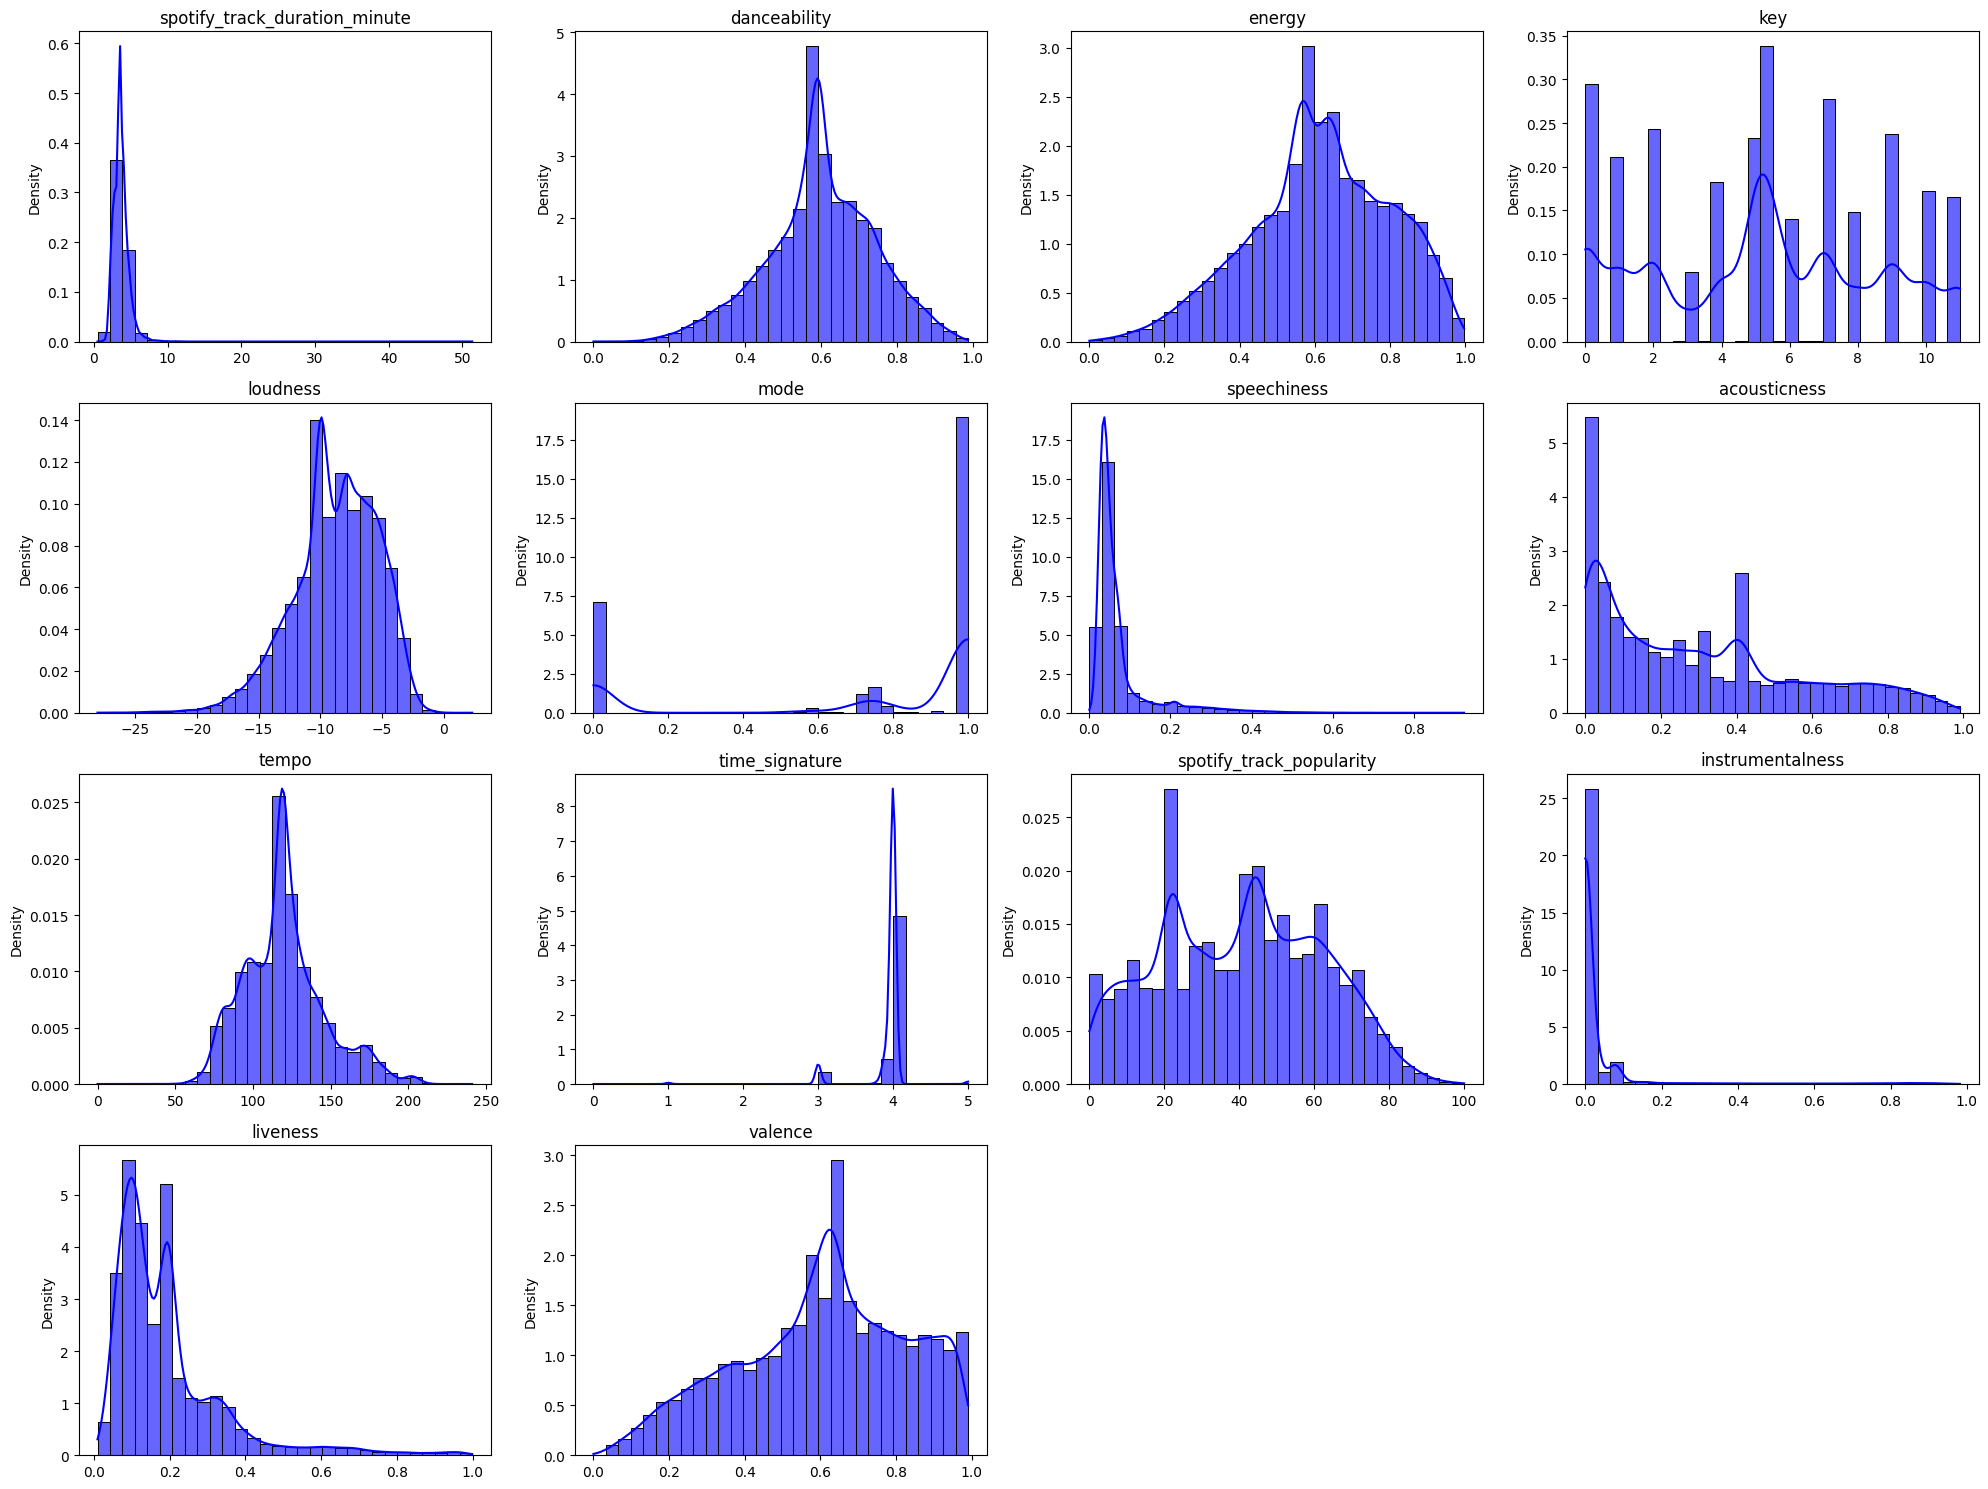

In [71]:
# HISTOGRAM FOR THE DISTRIBUTION 
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features):
    plt.subplot(4, 4, i + 1)
    sns.histplot(billboard_df_eda[feature], kde=True, bins=30, color='blue', stat="density", alpha=0.6)
    plt.title(feature)
    plt.xlabel('')
    plt.ylabel('Density')

plt.tight_layout()
plt.show()


# 2)

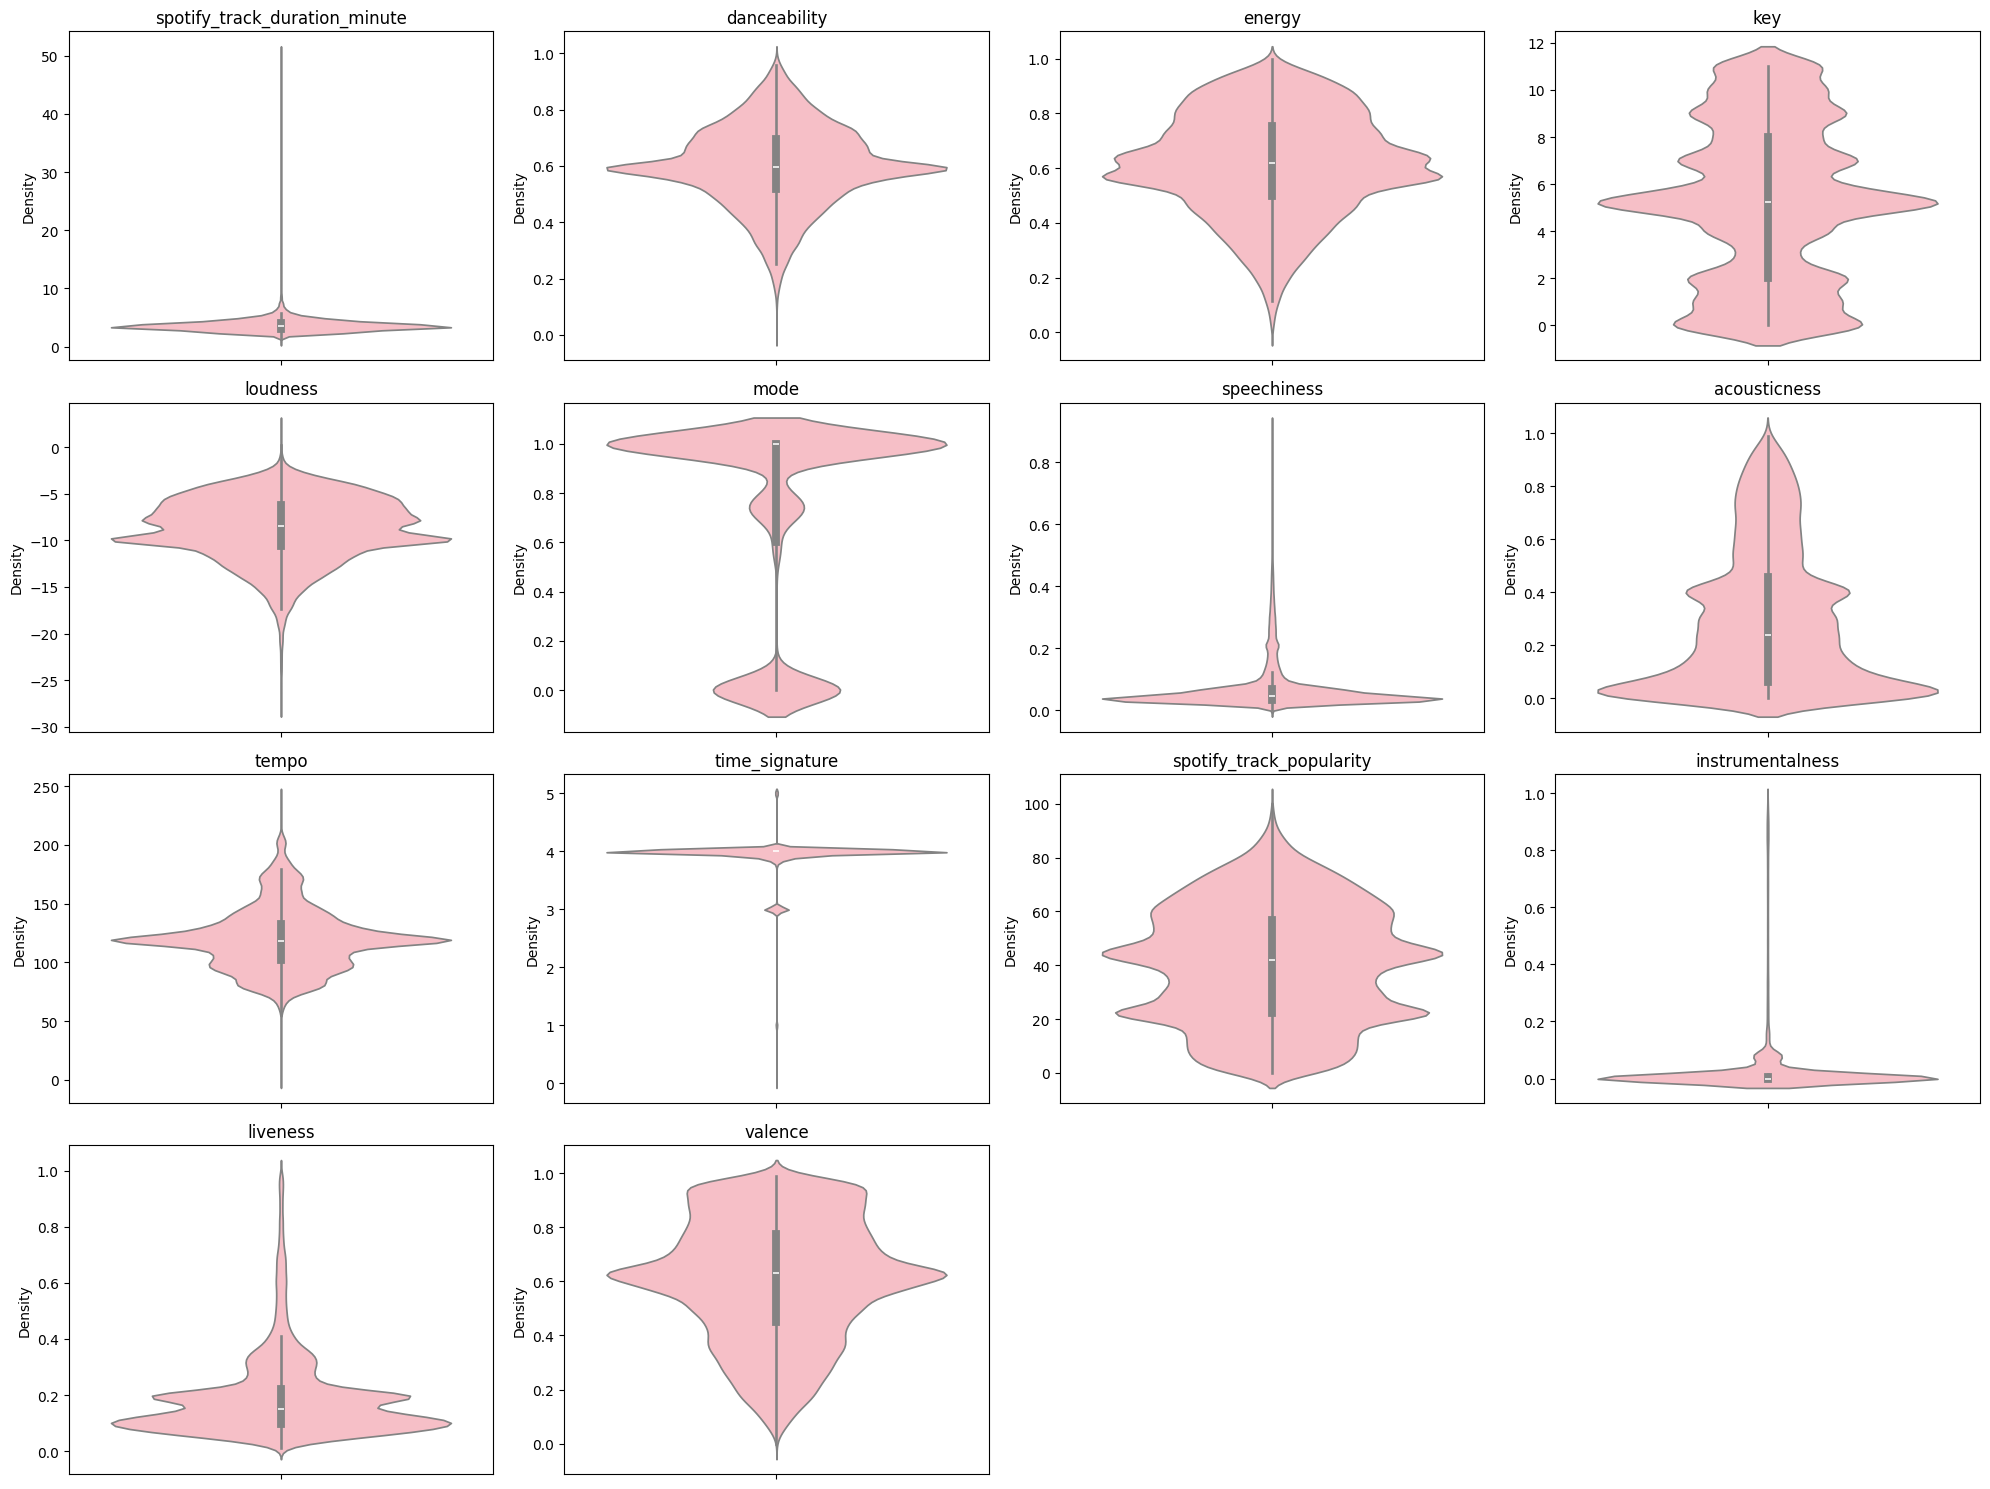

In [72]:
# BOXPLOT FOR IDENTITY OUTLIER
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features):
    plt.subplot(4, 4, i + 1)
    sns.violinplot(billboard_df_eda[feature],color='lightpink')
    plt.title(feature)
    plt.xlabel('')
    plt.ylabel('Density')

plt.tight_layout()
plt.show()


## IQR TECHNIQUE 

is a usefull technique in order to detect outliers

In [73]:
# We define the IQR function in order to detect outliers
def detect_outliers_iqr(df, features):
    outlier_indices = {}
    
    for feature in features:
        # Compute Q1 (25° percentile) e Q3 (75° percentile)
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        
        # Definition of the upper and lower bound
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Outlier identification
        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)].index
        outlier_indices[feature] = outliers.tolist()
    
    return outlier_indices

In [74]:
# Apply the function in order to detect out lier
outliers_iqr = detect_outliers_iqr(billboard_df_eda, features)
# for example we can accede to one of the feature and see, in wich index we have outliers
#outliers_iqr['loudness']

In [75]:
# example for loudness
#billboard_df_eda.loc[172]

## mean +/- 3*std methods

In [76]:
def detect_outliers_3(df,features):
    dict_out_ind= {}

    # i have to compute the mean and the std for each features
    for feature in features:
        mean_i=np.mean(billboard_df_eda[feature])
        std_i=np.std(billboard_df_eda[feature])

        # define the boundaries for each features
        lower_b=mean_i-3*std_i
        upper_b=mean_i+3*std_i

        # now we can detect the outliers
        outliers = df[(df[feature] < lower_b) | (df[feature] > upper_b)].index
        dict_out_ind[feature] = outliers.tolist()

    return dict_out_ind

### some test to see if works

In [77]:
#out_3=detect_outliers_3(billboard_df_eda,features)
#out_3.keys()

In [78]:
#for i in out_3.keys():
#    print(len(out_3[i]))

In [79]:
#out_3['danceability']

In [80]:
#billboard_df_eda.loc[2]

We can conclude that we don't have significative outliers, both methods give us similar results

# 3)

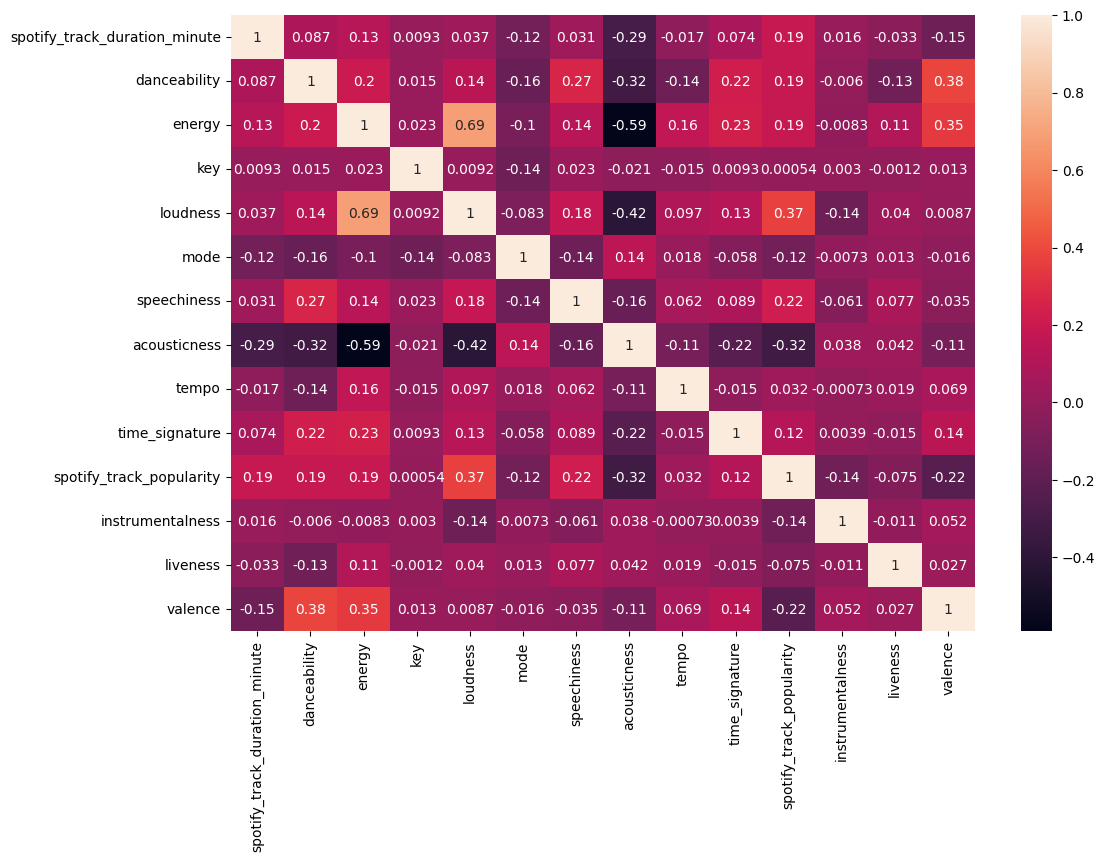

In [81]:
# now we buind an heatmap in order to understand if our feature are correlated
plt.figure(figsize=(12,8))
sns.heatmap(billboard_df_eda[features].corr(),annot=True)
plt.show()

we can notice:

- acousticness NEGATIVE CORRELATION with energy (-0.59)

- loudness NEGATIVE CORRELATION with acousticness (-0.42)

- valence POSITIVE CORRELATION with danceability (0.38)

- loudness POSITIVE CORRELATION with spotify_track_popularity (0.37)

- energy POSITIVE CORRELATION with valence (0.35)

---

In [82]:
%store billboard_df_eda 

Stored 'billboard_df_eda' (DataFrame)
